## Dual Governance Agent-based modelling


In [1]:
import pandas as pd
import numpy as np
from IPython.display import display, Markdown

# radCAD
from radcad import Model, Simulation, Experiment
from radcad.engine import Engine, Backend

pd.options.display.float_format = "{:.2f}".format

%matplotlib inline

In [34]:
from model.types.proposals import Proposal
from model.types.proposal_type import ProposalGeneration, ProposalSubType, ProposalType
from model.types.proposals import Proposal
from model.types.reaction_time import ModeledReactions
from model.types.scenario import Scenario
from model.utils.initialization import generate_initial_state
from model.state_update_blocks import state_update_blocks
from model.sys_params import sys_params
from model.utils.postprocessing import postprocessing


def setup_simulation(
    timesteps: int,
    monte_carlo_runs: int,
    proposals: list[Proposal],
    attackers: set[str],
    defenders: set[str],
    seed: int,
):
    simulations: list[Simulation] = []

    for run in range(monte_carlo_runs):
        seed_str = seed + run
        state = generate_initial_state(
            Scenario.SingleAttack,
            ModeledReactions.Normal,
            ProposalType.Negative,
            ProposalSubType.NoEffect,
            ProposalGeneration.Random,
            initial_proposals=proposals,
            attackers=attackers,
            defenders=defenders,
            seed=seed_str,
        )

        model = Model(initial_state=state, params=sys_params, state_update_blocks=state_update_blocks)

        simulation = Simulation(model=model, timesteps=timesteps, runs=1)
        simulations.append(simulation)

    experiments = Experiment(simulations)
    experiments.engine = Engine(
        backend=Backend.MULTIPROCESSING, processes=5, raise_exceptions=False, drop_substeps=True
    )

    return experiments


MONTE_CARLO_RUNS = 1
TIMESTEPS = 40
SEED = 141

proposals = [
    Proposal(
        timestep=2,
        damage=25,
        proposal_type=ProposalType.Negative,
        sub_type=ProposalSubType.FundsStealing,
        proposer="0x98078db053902644191f93988341e31289e1c8fe",
        attack_targets={
            "0xb671e841a8e6db528358ed385983892552ef422f",
            "0x4b4eec1ddc9420a5cc35a25f5899dc5993f9e586",
            "0x47176b2af9885dc6c4575d4efd63895f7aaa4790",
        },
    ),
]

attackers = {"0x98078db053902644191f93988341e31289e1c8fe", "0xc329400492c6ff2438472d4651ad17389fcb843a"}
defenders = {
    "0x3e40d73eb977dc6a537af587d48316fee66e9c8c",
    "0xc5c75caf067ae899a7ec10b86b5ab38c13879388",
    "0x32c98a981fe7c333bd4e8e7630e8e0cf5ce20987",
}

experiments = setup_simulation(TIMESTEPS, MONTE_CARLO_RUNS, proposals, attackers, defenders, SEED)

result = experiments.run()
df = pd.DataFrame(result)
post_processing = postprocessing(df)

submitting proposal with ID 1 at  2024-09-03 20:07:35.419302
2  attackers in the system that is going to steal  140661570039999992168448  stETH and  0  wstETH
stealing from honest actors  1.4066157004e+23  stETH and  0.0  wstETH
scheduling proposal with ID 1 at  2024-09-06 20:07:35.419302 that has been submitted at  2024-09-03 20:07:35


In [33]:
for run in range(MONTE_CARLO_RUNS):
    start_idx = run * TIMESTEPS
    end_idx = start_idx + TIMESTEPS

    submitted_proposals = post_processing.loc[end_idx - 1, "proposals_submitted_count"]
    canceled_proposals = post_processing.loc[end_idx - 1, "proposals_canceled_count"]
    proposals_damage = post_processing.loc[end_idx - 1, "total_damage_of_proposals"]
    average_damage = post_processing.loc[end_idx - 1, "average_damage_per_proposal"]

    display(Markdown(f"### Results summary for Monte Carlo Run {run + 1}"))
    display(Markdown(f"##### Submitted Proposals: **{submitted_proposals}**"))
    display(Markdown(f"##### Canceled Proposals: **{canceled_proposals}**"))
    display(Markdown(f"##### Total Damage of Proposals: **{proposals_damage}**"))
    display(Markdown(f"##### Average Damage per Proposal: **{average_damage}**"))

### Results summary for Monte Carlo Run 1

##### Submitted Proposals: **1**

##### Canceled Proposals: **0**

##### Total Damage of Proposals: **25**

##### Average Damage per Proposal: **25**

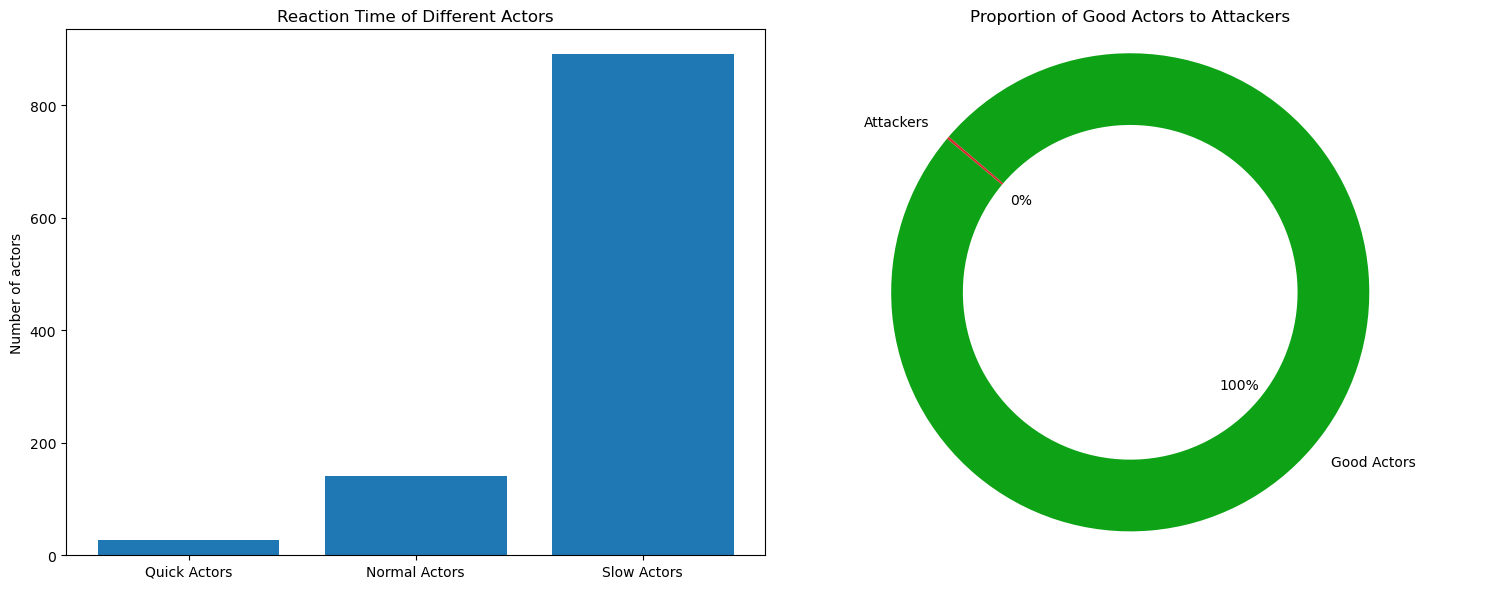

In [32]:
import matplotlib.pyplot as plt


def create_charts(post_processing, bar_charts, donut_chart):
    num_bar_charts = len(bar_charts)
    fig, axs = plt.subplots(1, num_bar_charts + 1, figsize=(7.5 * (num_bar_charts + 1), 6))

    if num_bar_charts == 1:
        axs = [axs[0], axs[1]]  # Ensure axs is always a list
    elif num_bar_charts == 2:
        axs = [axs[0], axs[1], axs[2]]

    # Plot bar charts
    for i, (attributes, labels, title, ylabel) in enumerate(bar_charts):
        values = [getattr(post_processing, attr).tail(1).values[0] for attr in attributes]
        axs[i].bar(labels, values)
        axs[i].set_title(title)
        axs[i].set_xlabel("")
        axs[i].set_ylabel(ylabel)

    # Plot donut chart
    labels, sizes, colors, title = donut_chart
    values = [getattr(post_processing, attr).tail(1).values[0] for attr in sizes]
    axs[-1].pie(
        values,
        labels=labels,
        colors=colors,
        autopct=lambda p: f"{p:.0f}%" if p > 0 else "0",
        startangle=140,
        wedgeprops=dict(width=0.3),
    )
    axs[-1].set_title(title)
    axs[-1].axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.tight_layout()
    plt.show()


# Example usage
values = [
    "total_quick_actors_reaction_time",
    "total_normal_actors_reaction_time",
    "total_slow_actors_reaction_time",
]
# values_2 = [
#     "total_full_governance_participants",
#     "total_normal_governance_participants",
#     "total_abstaining_governance_participants",
# ]

labels = ["Quick Actors", "Normal Actors", "Slow Actors"]
labels_2 = ["Full Participation", "Normal Participation", "Abstaining Participation"]

chart_1 = (values, labels, "Reaction Time of Different Actors", "Number of actors")
# chart_2 = (values_2, labels_2, "Governance Participation of Different Actors", "Number of actors")

donut_chart = (
    ["Good Actors", "Attackers"],
    ["total_stETH_good_actors", "total_attackers"],
    ["#0EA317", "#D6292F"],
    "Proportion of Good Actors to Attackers",
)

create_charts(post_processing, [chart_1], donut_chart)

In [59]:
def create_donut_charts(post_processing, donut_charts, monte_carlo_runs, timesteps):
    num_charts_per_run = len(donut_charts)
    fig, axs = plt.subplots(
        monte_carlo_runs, num_charts_per_run, figsize=(6 * num_charts_per_run, 4 * monte_carlo_runs)
    )

    for run in range(monte_carlo_runs):
        start_idx = run * timesteps
        end_idx = start_idx + timesteps

        for i, (labels, sizes, colors, title) in enumerate(donut_charts):
            values = [post_processing.loc[end_idx - 1, attr] for attr in sizes]
            total = sum(values)

            if monte_carlo_runs == 1 and num_charts_per_run == 1:
                ax = axs
            elif monte_carlo_runs == 1:
                ax = axs[i]
            else:
                ax = axs[run, i]

            ax.pie(
                values,
                labels=labels,
                colors=colors,
                autopct=lambda p: f"{p:.0f}% ({p * total / 100:.0f})" if p > 0 else "0",
                startangle=140,
                wedgeprops=dict(width=0.25, edgecolor="w", linewidth=0.25),
                textprops=dict(color="black", fontsize=10),
            )
            ax.set_title(title)
            ax.axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.tight_layout()
    plt.show()

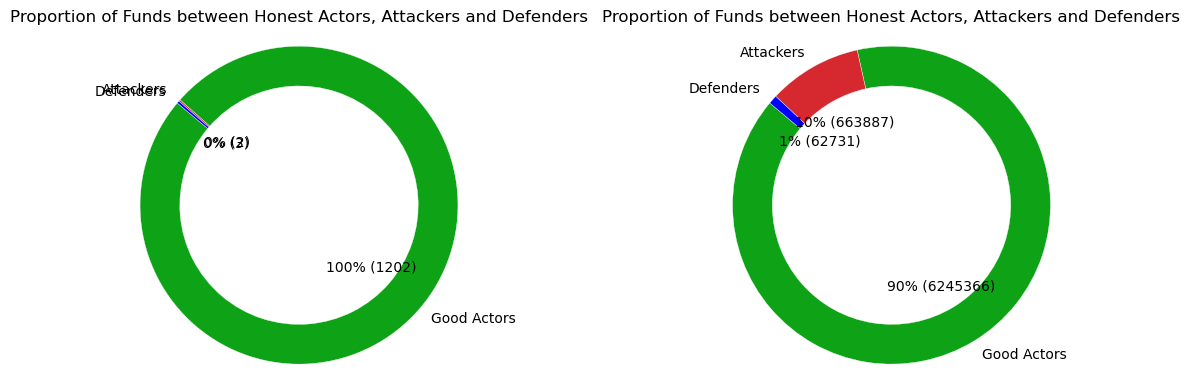

In [61]:
funds_distribution_actor_types = (
    ["Good Actors", "Attackers", "Defenders"],
    ["total_honest_actors_funds", "total_attackers_actors_funds", "total_defenders_actors_funds"],
    ["#0EA317", "#D6292F", "blue"],
    "Proportion of Funds between Honest Actors, Attackers and Defenders",
)

actors_distribution_actor_types = (
    ["Good Actors", "Attackers", "Defenders"],
    ["total_stETH_good_actors", "total_attackers", "total_defenders"],
    ["#0EA317", "#D6292F", "blue"],
    "Proportion of Funds between Honest Actors, Attackers and Defenders",
)

create_donut_charts(post_processing, [actors_distribution_actor_types, funds_distribution_actor_types], 1, TIMESTEPS)

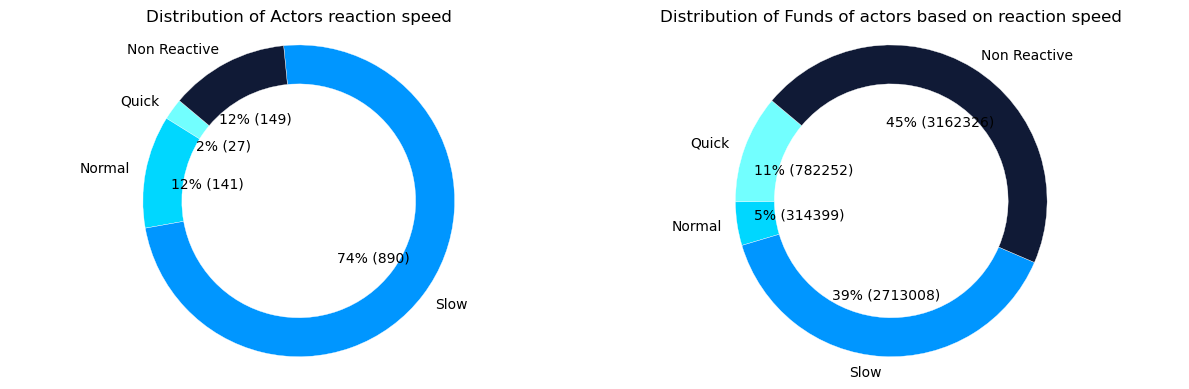

In [40]:
actors_distribution = (
    ["Quick", "Normal", "Slow", "Non Reactive"],
    [
        "total_quick_actors_reaction_time",
        "total_normal_actors_reaction_time",
        "total_slow_actors_reaction_time",
        "total_non_reactive_actors_reaction_time",
    ],
    ["#72FFFF", "#00D7FF", "#0096FF", "#101A36"],
    "Distribution of Actors reaction speed",
)

total_quick_actors_funds = post_processing["total_stETH_quick_actors"] + post_processing["total_wstETH_quick_actors"]

funds_distribution = (
    ["Quick", "Normal", "Slow", "Non Reactive"],
    [
        "total_quick_actors_funds",
        "total_normal_actors_funds",
        "total_slow_actors_funds",
        "total_non_reactive_actors_funds",
    ],
    ["#72FFFF", "#00D7FF", "#0096FF", "#101A36"],
    "Distribution of Funds of actors based on reaction speed",
)


create_donut_charts(post_processing, [actors_distribution, funds_distribution], MONTE_CARLO_RUNS, TIMESTEPS)

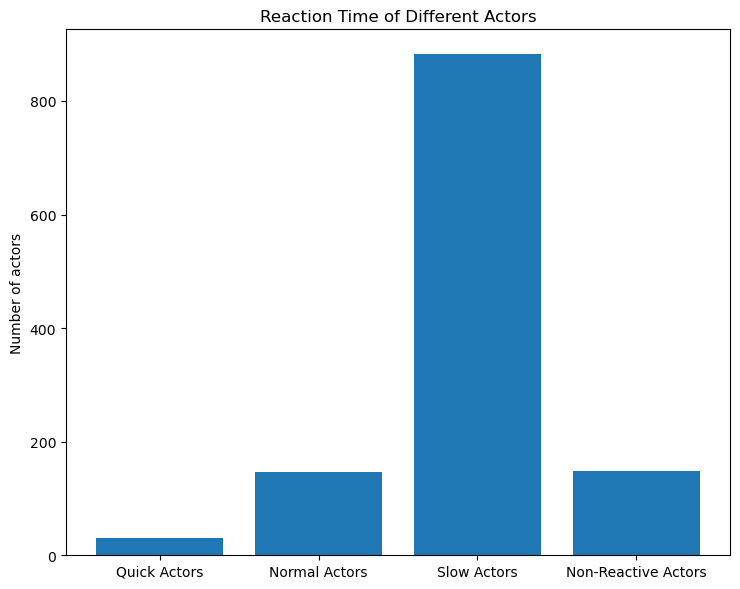

In [10]:
from model.utils.charts import create_bar_charts

values = [
    "total_quick_actors_reaction_time",
    "total_normal_actors_reaction_time",
    "total_slow_actors_reaction_time",
    "total_non_reactive_actors_reaction_time",
]

labels = ["Quick Actors", "Normal Actors", "Slow Actors", "Non-Reactive Actors"]
labels_2 = ["Full Participation", "Normal Participation", "Abstaining Participation", "Non-Participating"]

chart_1 = (values, labels, "Reaction Time of Different Actors", "Number of actors")

create_bar_charts(post_processing, chart_1)

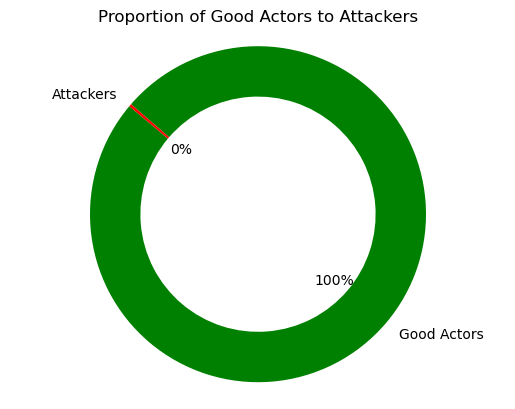

In [11]:
labels = "Good Actors", "Attackers"
sizes = ["total_stETH_good_actors", "total_attackers"]
values = [getattr(post_processing, attr).tail(1).values[0] for attr in sizes]
colors = ["green", "red"]
autopct = lambda p: f"{p:.0f}%" if p > 0 else "0"

plt.pie(
    values,
    labels=labels,
    colors=colors,
    autopct=lambda p: f"{p:.0f}%" if p > 0 else "0",
    startangle=140,
    wedgeprops=dict(
        width=0.3,
    ),
)

plt.axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Proportion of Good Actors to Attackers")
plt.show()

In [12]:
post_processing.head(1)

,dg_state,current_time,total_actors_health,total_contracts_health,total_honest_actors_health,total_attackers_actors_health,total_actors_damaged,total_actors_recovery,total_stETH_balance,total_stETH_locked,...,total_quick_actors_funds,total_normal_actors_funds,total_slow_actors_funds,total_non_reactive_actors_funds,total_stETH_good_actors,total_attackers,total_honest_actors_funds,total_attackers_actors_funds,timestep,simulation
1,State.Normal,2024-09-03 19:42:57.240319,60037.00,7645,59826,152.00,0,0,4687871.40,0.00,...,765344.65,369422.68,2674891.35,3162325.50,1203,3,6267903.06,664440.51,1,1


In [13]:
post_processing.tail(5)

,dg_state,current_time,total_actors_health,total_contracts_health,total_honest_actors_health,total_attackers_actors_health,total_actors_damaged,total_actors_recovery,total_stETH_balance,total_stETH_locked,...,total_quick_actors_funds,total_normal_actors_funds,total_slow_actors_funds,total_non_reactive_actors_funds,total_stETH_good_actors,total_attackers,total_honest_actors_funds,total_attackers_actors_funds,timestep,simulation
36,State.Normal,2024-09-08 04:42:57.240319,26339.79,7611,26151,163.79,25176,0,4597227.08,90644.32,...,765344.65,369422.68,2674891.35,3162325.50,1203,3,6267903.06,664440.51,36,1
37,State.Normal,2024-09-08 07:42:57.240319,26339.79,7611,26151,163.79,25176,0,4597227.08,90644.32,...,765344.65,369422.68,2674891.35,3162325.50,1203,3,6267903.06,664440.51,37,1
38,State.Normal,2024-09-08 10:42:57.240319,26339.79,7611,26151,163.79,25176,0,4597227.08,90644.32,...,765344.65,369422.68,2674891.35,3162325.50,1203,3,6267903.06,664440.51,38,1
39,State.Normal,2024-09-08 13:42:57.240319,26339.79,7611,26151,163.79,25176,0,4597227.08,90644.32,...,765344.65,369422.68,2674891.35,3162325.50,1203,3,6267903.06,664440.51,39,1
40,State.Normal,2024-09-08 16:42:57.240319,26339.79,7611,26151,163.79,25176,0,4597227.08,90644.32,...,765344.65,369422.68,2674891.35,3162325.50,1203,3,6267903.06,664440.51,40,1


#### Results Summary for Run 1

##### Time from maximum normalized_damaged to maximum combined_percentage_locked: **69 hours** (2.88 days)

##### Maximum percentage of rage quit support : **1.78 %**

##### Maximum number of locked tokens : **108893.14 stETH** and **15273.90 wstETH**

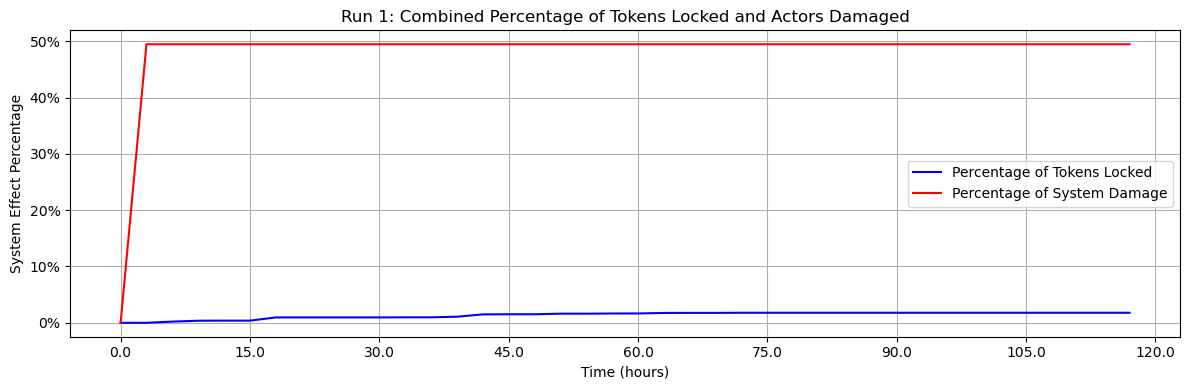

In [24]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

for run in range(MONTE_CARLO_RUNS):
    start_idx = run * TIMESTEPS
    end_idx = start_idx + TIMESTEPS

    total_stETH_balance = post_processing["total_stETH_balance"].iloc[start_idx:end_idx]
    total_stETH_locked = post_processing["total_stETH_locked"].iloc[start_idx:end_idx]
    total_wstETH_balance = post_processing["total_wstETH_balance"].iloc[start_idx:end_idx]
    total_wstETH_locked = post_processing["total_wstETH_locked"].iloc[start_idx:end_idx]
    total_actors_damaged = post_processing["total_actors_damaged"].iloc[start_idx:end_idx]
    total_actors_health = post_processing["total_actors_health"].iloc[start_idx:end_idx]
    total_actors_recovery = post_processing["total_actors_recovery"].iloc[start_idx:end_idx]
    rage_quit_support = post_processing["rage_quit_support"].iloc[start_idx:end_idx]
    timesteps = range(len(total_stETH_balance))

    combined_balance = total_stETH_balance + total_wstETH_balance + total_stETH_locked + total_wstETH_locked
    combined_locked = total_stETH_locked + total_wstETH_locked

    percentage_locked = [
        (locked / balance) if balance != 0 else 0 for locked, balance in zip(combined_locked, combined_balance)
    ]

    normalized_damaged = [
        (damaged - recovery) / (health + damaged - recovery)
        for damaged, recovery, health in zip(total_actors_damaged, total_actors_recovery, total_actors_health)
    ]

    max_normalized_damaged_idx = normalized_damaged.index(max(normalized_damaged))
    max_normalized_damaged_ts = timesteps[max_normalized_damaged_idx]

    max_combined_percentage_locked_idx = percentage_locked.index(max(percentage_locked))
    max_combined_percentage_locked_ts = timesteps[max_combined_percentage_locked_idx]

    time_difference = max_combined_percentage_locked_ts - max_normalized_damaged_ts
    time_difference_hours = time_difference * 3
    time_difference_days = time_difference_hours / 24

    display(Markdown(f"#### Results Summary for Run {run + 1}"))
    display(
        Markdown(
            f"##### Time from maximum normalized_damaged to maximum combined_percentage_locked: **{time_difference_hours} hours** ({time_difference_days:.2f} days)"
        )
    )
    display(Markdown(f"##### Maximum percentage of rage quit support : **{rage_quit_support.max():.2f} %**"))
    display(
        Markdown(
            f"##### Maximum number of locked tokens : **{total_stETH_locked.max():.2f} stETH** and **{total_wstETH_locked.max():.2f} wstETH**"
        )
    )

    plt.figure(figsize=(12, 4))
    plt.plot(timesteps, percentage_locked, color="blue", label="Percentage of Tokens Locked")
    plt.plot(timesteps, normalized_damaged, color="red", label="Percentage of System Damage")
    plt.xlabel("Time (hours)")
    plt.ylabel("System Effect Percentage")
    plt.title(f"Run {run + 1}: Combined Percentage of Tokens Locked and Actors Damaged")
    plt.legend()
    plt.grid(True)
    plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))
    plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{x * 3}"))
    plt.tight_layout()
    plt.show()

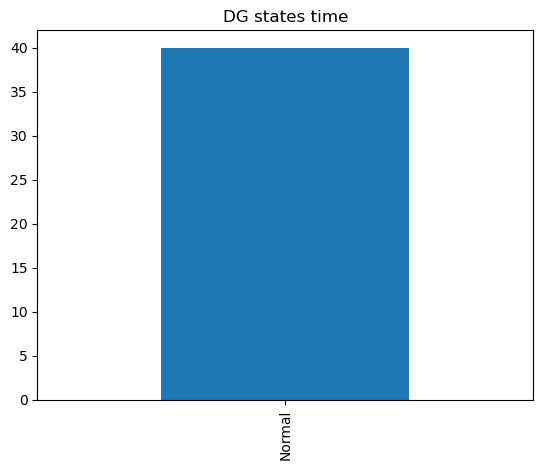

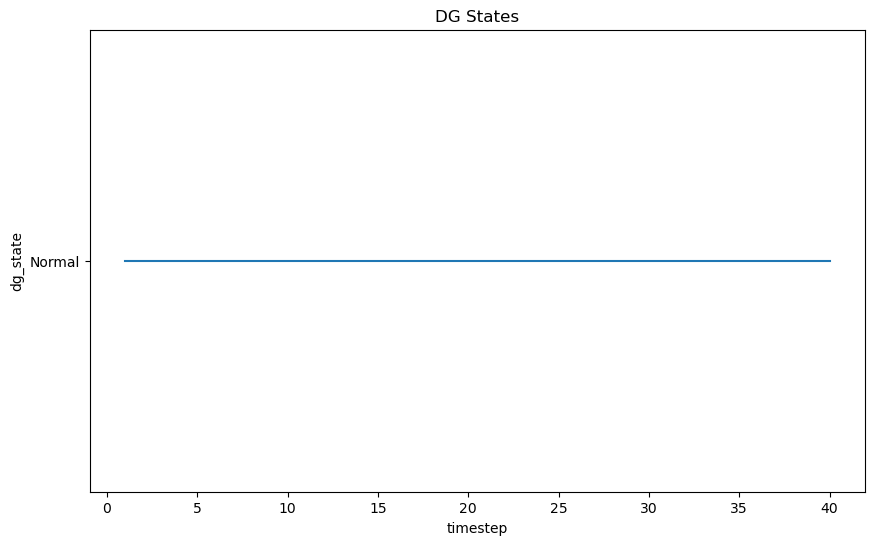

In [15]:
from model.utils.charts import state_plot, monte_carlo_plot


state_plot(post_processing, "timestep", "dg_state", 1)

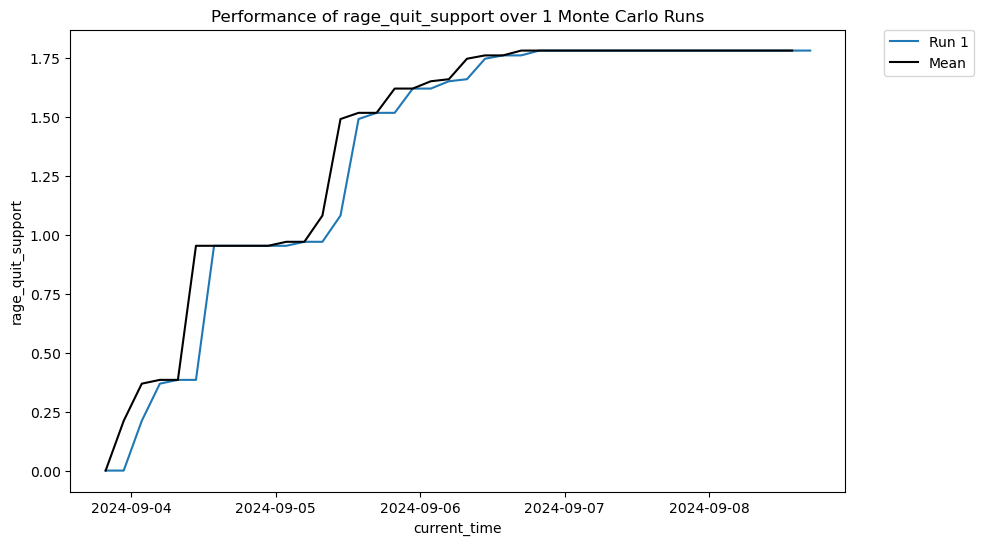

In [25]:
monte_carlo_plot(post_processing, "timestep", "current_time", "rage_quit_support", MONTE_CARLO_RUNS)

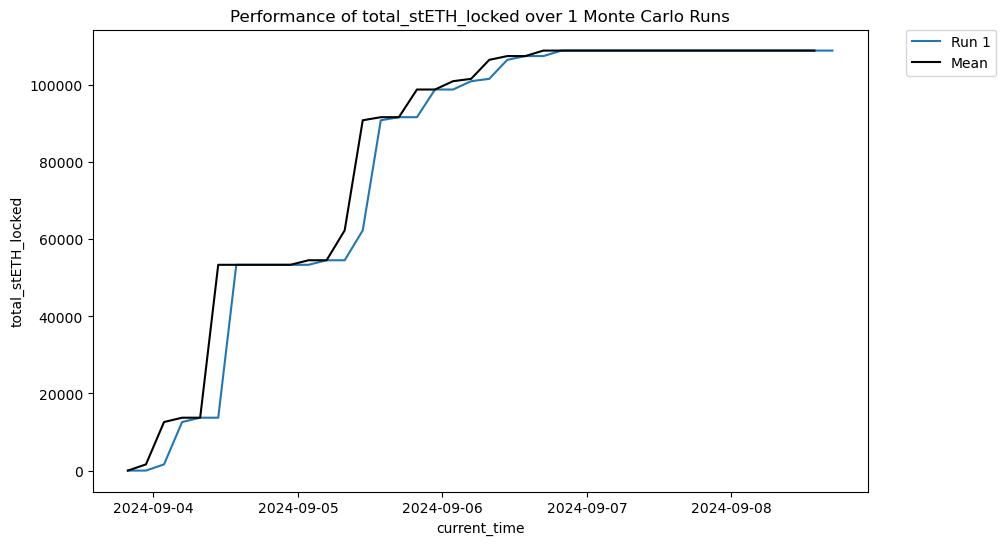

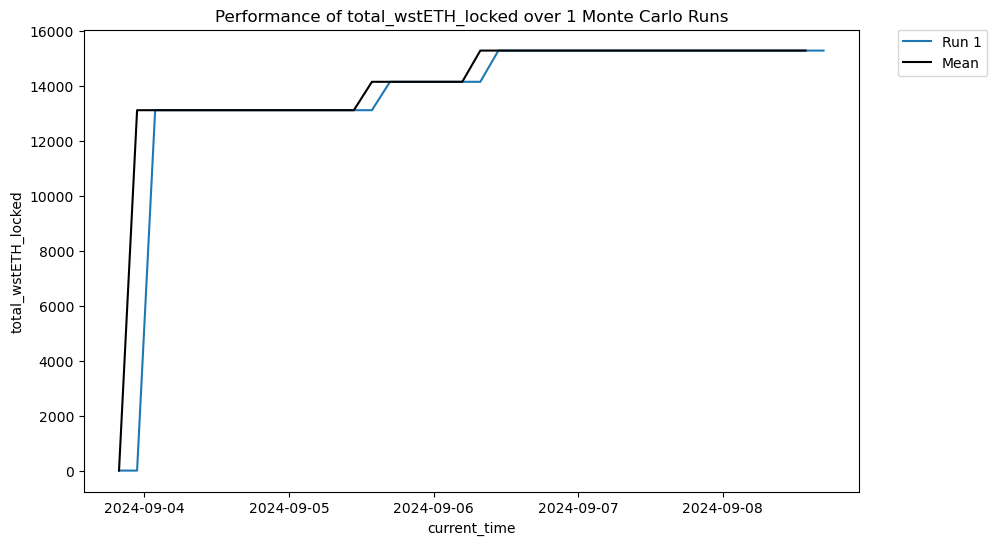

In [26]:
monte_carlo_plot(post_processing, "timestep", "current_time", "total_stETH_locked", MONTE_CARLO_RUNS)
monte_carlo_plot(post_processing, "timestep", "current_time", "total_wstETH_locked", MONTE_CARLO_RUNS)